In [6]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from tqdm import tqdm

from typing import List
from collections import Counter
from itertools import chain
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [8]:
reviews = pd.read_csv('shopee_reviews.csv')
reviews.columns = ['mark', 'review']
reviews.head()

,mark,review
0,5,Looks ok. Not like so durable. Will hv to use ...
1,5,"Tried, the current can be very powerful depend..."
2,5,Item received after a week. Looks smaller than...
3,5,Thanks!!! Works as describe no complaints. Not...
4,5,Fast delivery considering it’s from overseas a...


In [9]:
def build_vocab(reviews: List[str]) -> Counter:
    words = list(chain.from_iterable([text.split() for text in reviews]))
    vocab = Counter(words)
    return vocab

In [10]:
res = pd.DataFrame(columns=['mark', 'review'])
for mark in range(1, 5 + 1):
    res = res.append(reviews[reviews.mark == mark].sample(10000), ignore_index=True)
reviews = res

In [11]:
vocab = build_vocab(reviews.review.tolist())
print(len(vocab))
list(vocab.items())[:13]

47911


[('Only', 455),
 ('received', 5512),
 ('2', 2487),
 ('out', 2081),
 ('of', 8892),
 ('3', 1164),
 ('orders.', 20),
 ('Buttons', 17),
 ('do', 745),
 ('not', 13163),
 ('button', 227),
 ('well.', 918),
 ('The', 6297)]

In [12]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tema\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
eng_stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [14]:
def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    
    cleaned_words = []
    for word in text.split():
        if word in eng_stopwords:
            continue
        cleaned_words.append(stemmer.stem(word))

    return ' '.join(cleaned_words)


texts = []
for text in tqdm(reviews.review.tolist()):
    texts.append(preprocess_text(text))
vocab = build_vocab(texts)
        
print(len(vocab))
vocab.most_common(10)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:08<00:00, 6029.47it/s]

17840


[('good', 11718),
 ('receiv', 11088),
 ('item', 9947),
 ('deliveri', 8564),
 ('seller', 6861),
 ('order', 5875),
 ('qualiti', 5751),
 ('size', 5133),
 ('fast', 4972),
 ('product', 4615)]

In [15]:
cleaned_vocab = list(filter(lambda x: x[1] > 3, vocab.items()))
cleaned_words = [k for k, v in cleaned_vocab]
print(len(cleaned_words))

4535


In [16]:
from gensim.models import Word2Vec

def filtered_text(text):
    return list(filter(lambda word: word in cleaned_words, text.split()))

model = Word2Vec(sentences=[filtered_text(text) for text in tqdm(texts)],
                 sg=False,  # cbow model
                 vector_size=100,
                 window=5,
                 seed=42,
                 epochs=40, 
                 min_count=1
                 )
print('размерность векторов слов в модели:', model.wv.vectors.shape)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9058.07it/s]


размерность векторов слов в модели: (4535, 100)


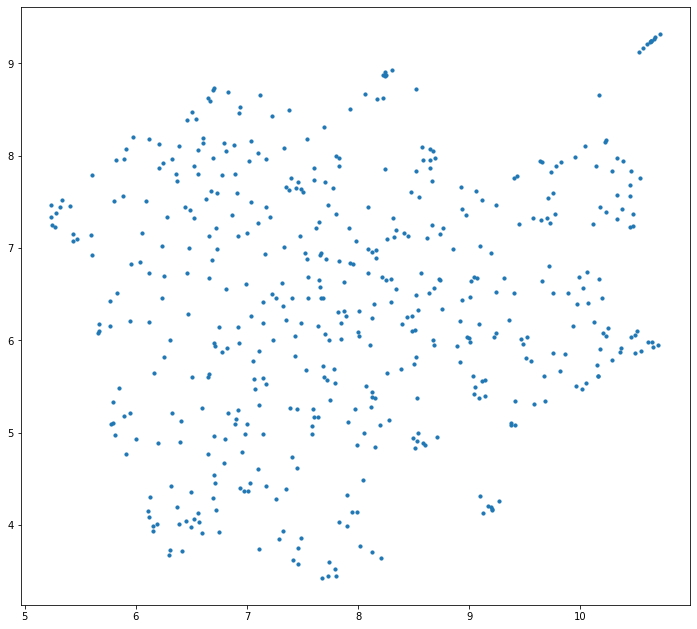

In [17]:
points = umap.UMAP(random_state=42).fit_transform(model.wv.vectors[:500])
plt.figure(figsize=(12, 11))
plt.scatter(x=points[:, 0], y=points[:, 1], s=10)

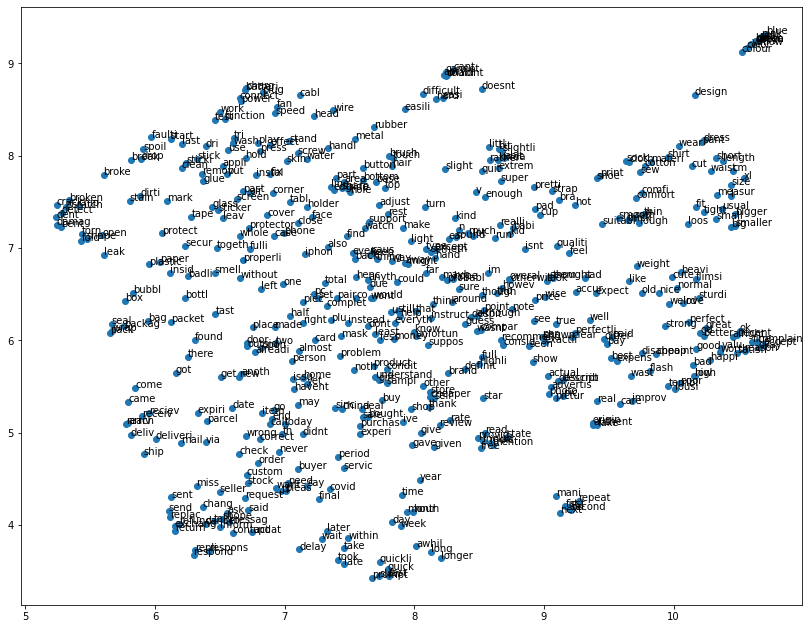

In [18]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.scatter(points[:, 0], points[:, 1])

for i, txt in enumerate(model.wv.index_to_key[:500]):
    ax.annotate(txt, (points[i, 0], points[i, 1]))

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

class Utils:
    
    def __init__(self, words, word_to_vec_f):
        self.words_dict = dict(zip(words, range(len(words))))
        self.converter = word_to_vec_f
        self.cosin_matrix = self.build_cosine_matrix(words, word_to_vec_f)
        
    def get_embed(self, word):
        return self.converter(word)
        
    def build_cosine_matrix(self, words, func):
        np_words = np.array([func(word) for word in tqdm(words)])
        return cosine_similarity(np_words, np_words)

    def common(self, word1, word2, f):
        a, b = np.array(self.converter(word1)), np.array(self.converter(word2))
        return f(a, b)
    
    def subwords(self, word1, word2):
        return self.common(word1, word2, lambda a, b: a-b)

    def sumwords(self, word1, word2):
        return self.common(word1, word2, lambda a, b: a+b)
    
    def similar_helper(self, vector):
        temp = [(w, cosine_similarity([self.converter(w)], [vector])[0][0]) for w in self.words_dict.keys()]
        temp.sort(key=lambda x:-x[1])
        return temp
    
    def similar(self, vector, count=1):
        temp = self.similar_helper(vector)
        return temp[2:2+count]
    
    def unsimilar(self, vector, count=1):
        temp = self.similar_helper(word)
        return sorted(temp[-count-2:-2], key=lambda x: x[1])
    
    def close_helper(self, word):
        word_index = self.words_dict[word]
        temp = [(i, w, self.cosin_matrix[word_index][i]) for w, i in filter(lambda x: x[0] != word, self.words_dict.items())]
        temp.sort(key=lambda x:-x[2])
        return temp
    
    def close(self, word, count=1):
        temp = self.close_helper(word)
        return temp[:count]
    
    def unclose(self, word, count=1):
        temp = self.close_helper(word)
        return sorted(temp[-count:], key=lambda x: x[2])

In [20]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model_bert = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # возращать эмбеддинги каждого слова
                                  )
model_bert.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [21]:
len(list(tokenizer.vocab.keys()))

30522

In [22]:
gensim_utils = Utils(cleaned_words, model.wv.get_vector)

100%|██████████████████████████████████████████████████████████████████████████| 4535/4535 [00:00<00:00, 911630.42it/s]


In [23]:
def make_word_embedding(word: str) -> torch.Tensor:
    # Получим индексы токенов
    tokenized_query = tokenizer.tokenize(word)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_query)
    segments_ids = [1] * len(indexed_tokens)
    
    # to tensor 
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    # calc embeddings
    outputs = model_bert(tokens_tensor, segments_tensors)
    return outputs[2][-1].squeeze(0).sum(dim=0).tolist()

bert_utils = Utils(cleaned_words, make_word_embedding)

100%|██████████████████████████████████████████████████████████████████████████████| 4535/4535 [01:53<00:00, 39.87it/s]


In [24]:
gensim_utils.sumwords("china", "blue")

array([-3.4785488 , -2.2049987 , -0.29474765,  4.443418  , -0.10767603,
        1.0889347 ,  2.851743  ,  0.8144647 ,  0.21686399,  1.6370357 ,
        1.092556  ,  3.0890346 ,  2.9127553 ,  0.6646101 ,  0.95460486,
        1.0434936 , -0.31714416,  1.8658148 , -0.29541707, -0.3512629 ,
        1.7368145 , -3.2424548 , -1.5407323 , -0.56432223, -0.54819065,
       -1.5118353 ,  3.626271  ,  0.63159484,  1.9942975 ,  0.54932547,
       -2.5934587 , -2.9819663 ,  0.75795895, -1.5027447 ,  0.9997966 ,
        0.8645837 ,  0.35062152, -1.1397178 , -3.214288  , -1.0361454 ,
        4.685751  ,  2.987801  ,  1.5763632 ,  0.00862169, -1.3637794 ,
       -0.8254276 , -1.1999419 ,  0.42833176, -0.9986418 ,  0.8378858 ,
       -2.4445608 , -1.1674898 ,  4.0838833 ,  1.1658406 , -4.8310714 ,
        2.41636   ,  1.6564354 ,  0.30850932,  0.9880822 ,  1.098824  ,
       -3.3698802 , -1.1734957 , -1.191697  , -0.19373679, -1.6349269 ,
       -0.55897075, -1.6120625 ,  2.6638212 ,  0.6350509 , -0.34

In [25]:
gensim_utils.similar(gensim_utils.sumwords("china", "red"), count = 5)

[('korea', 0.48023483),
 ('orang', 0.43822202),
 ('indonesia', 0.43302265),
 ('purpl', 0.42136636),
 ('brown', 0.40591264)]

In [26]:
bert_utils.similar(bert_utils.subwords("china", "red"), count = 5)

[('thai', 0.2753377775108625),
 ('korean', 0.2690018693122354),
 ('think', 0.25987276426475947),
 ('mandarin', 0.25390809864467273),
 ('junk', 0.2499359291946373)]

In [27]:
gensim_utils.close("great", count=5)

[(176, 'good', 0.7132881),
 (2012, 'excel', 0.59083545),
 (975, 'perfect', 0.55846),
 (556, 'decent', 0.50705457),
 (2133, 'awesom', 0.49724576)]

In [28]:
bert_utils.close("great", count=10)

[(2604, 'greatli', 0.7066204942671389),
 (2411, 'ghost', 0.681544195122148),
 (3459, 'charm', 0.6768614403206125),
 (304, 'total', 0.6722599706721409),
 (3205, 'gum', 0.6698482530313793),
 (60, 'phone', 0.6657556419044484),
 (4528, 'goodthank', 0.6617772126548593),
 (4369, 'collector', 0.6613407212405064),
 (176, 'good', 0.6610569643466057),
 (1015, 'kit', 0.6608439830537325)]

In [29]:
corpus_vocab = sorted(cleaned_vocab, key=lambda x: -x[1])[:2000]
print(corpus_vocab[:10])
corpus = [i[0] for i in corpus_vocab]

[('good', 11718), ('receiv', 11088), ('item', 9947), ('deliveri', 8564), ('seller', 6861), ('order', 5875), ('qualiti', 5751), ('size', 5133), ('fast', 4972), ('product', 4615)]


In [35]:
embeddings = [gensim_utils.get_embed(i) for i in corpus]
#print(embeddings[0])
embeddings[1999]

array([ 0.14141782, -0.3155161 , -0.89854115, -0.1443974 , -0.20301919,
       -0.5681727 ,  0.02268402,  0.01208479, -0.47003767, -0.2474017 ,
       -0.3543265 , -0.8438416 , -0.8404901 , -0.08954506,  0.13164195,
       -0.01136152,  0.18380874, -0.16205138, -0.29479283, -0.20045735,
        0.3576158 , -0.18275201, -0.04832802,  0.18924488, -0.31212774,
        0.26014814,  0.38309497, -0.02520692, -0.8579614 ,  0.66100913,
        0.29275858, -0.07984959,  0.18362296, -0.39655322,  0.10780883,
       -0.31468773, -0.07524206, -0.72579694,  0.3621271 ,  1.0878043 ,
        0.45086032, -0.19387926, -0.16242178,  0.15966822,  0.875682  ,
       -0.10869735,  0.5216102 ,  0.19986783,  0.66068697, -0.49239165,
       -0.5935161 , -0.5186183 , -0.42455548, -0.00520795, -0.75175345,
        0.285063  , -0.01594261, -0.00187277, -0.45049015,  0.36474842,
        0.19560415, -0.07077743, -0.35104322,  0.03695571,  0.16923329,
        0.4296085 ,  0.2765246 , -0.3505696 , -0.3369865 ,  0.45

In [36]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()

writer.add_embedding(embeddings,
                     metadata=corpus)
writer.close()

In [37]:
%load_ext tensorboard

In [38]:
%tensorboard --logdir runs --bind_all